<h2>Random Forest, Decision Trees, Gradient Boosting using XGBoost/LightGBM/CatBoost, AdaBoost</h2>

<h3>Random Forest -- Ensemble method which handles mixed data types, feature importance, and is very robust</h3>

In [2]:
import pandas as pd

df = pd.read_csv("datasets/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
df['pass_all'] = (
    (df['math score'] >= 50) &
    (df['reading score'] >= 50) &
    (df['writing score'] >= 50)
).astype(int)

X = df.drop(['math score', 'reading score', 'writing score', 'pass_all'], axis=1)
y = df['pass_all']

X = pd.get_dummies(X, drop_first=True) # One hot encoding

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 12  26]
 [ 18 144]]
              precision    recall  f1-score   support

           0       0.40      0.32      0.35        38
           1       0.85      0.89      0.87       162

    accuracy                           0.78       200
   macro avg       0.62      0.60      0.61       200
weighted avg       0.76      0.78      0.77       200



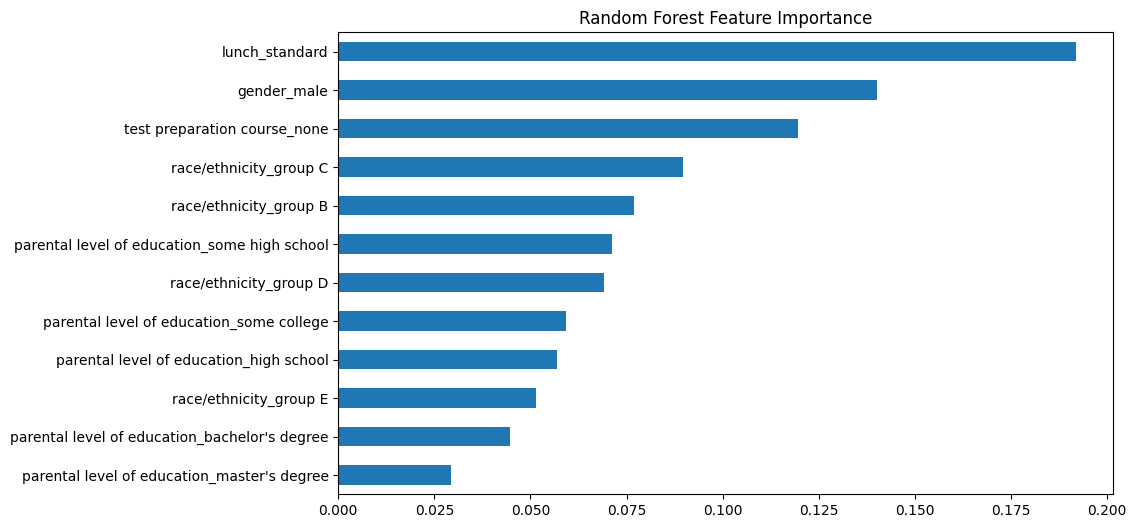

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.show()

In [12]:
# Let's attempt to fix the weaknesses of struggling with class 0, i.e. failing students, low precision, and imbalance of passers vs failers that likely skews the model 
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # <-- THIS IS KEY
    random_state=42
)
rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)

In [13]:
print(confusion_matrix(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

[[ 14  24]
 [ 42 120]]
              precision    recall  f1-score   support

           0       0.25      0.37      0.30        38
           1       0.83      0.74      0.78       162

    accuracy                           0.67       200
   macro avg       0.54      0.55      0.54       200
weighted avg       0.72      0.67      0.69       200



In [15]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [17]:
# This can still be improved, and we can use SMOTE resampling, preprocessing technique used to address a class imbalance in a dataset

from imblearn.over_sampling import SMOTE

X_train = X_train.astype(int)
X_test = X_test.astype(int)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_res, y_train_res)

y_pred_smote = rf_smote.predict(X_test)

print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

[[ 21  17]
 [ 51 111]]
              precision    recall  f1-score   support

           0       0.29      0.55      0.38        38
           1       0.87      0.69      0.77       162

    accuracy                           0.66       200
   macro avg       0.58      0.62      0.57       200
weighted avg       0.76      0.66      0.69       200



<h3>Decision Trees</h3>

<h3>Gradient Boosting using XGBoost/LightGBM/CatBoost</h3>

<h3>AdaBoost</h3>